# Computer Vision -Optical Flow 

# Original Video Sample

In [2]:
import cv2
from IPython.display import display, HTML
import io
import base64

# Read the video
cap = cv2.VideoCapture('traffic.mp4')

# Check if the video is opened successfully
if not cap.isOpened():
    print("Error: Unable to open video.")
    exit()

# Define function to display video
def display_video(path):
    video = io.open(path, 'r+b').read()
    encoded = base64.b64encode(video)
    display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 300px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))

# Display the video
display_video('traffic.mp4')

# Release the video capture object
cap.release()


# Sparse Optical Flow:

# Lucas-Kanade algorithm 

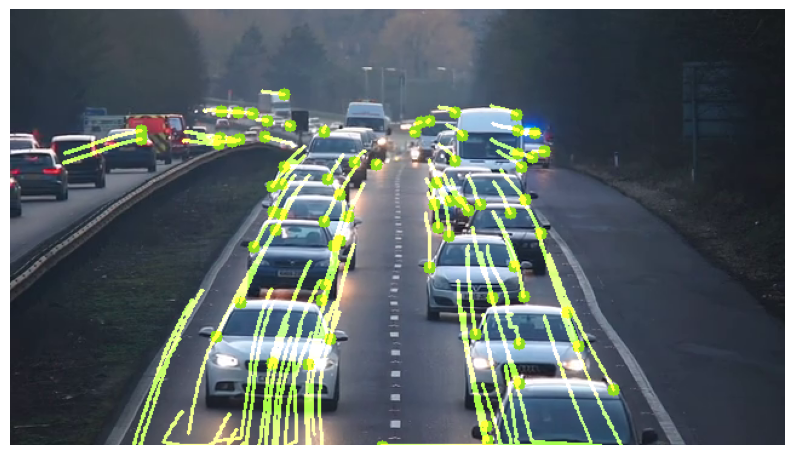

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def lucas_kanade_method(video_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Parameters for Shi-Tomasi corner detection
    feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    # Create some random colors
    color = np.random.randint(0, 255, (100, 3))
    
    # Take first frame and find corners in it
    ret, old_frame = cap.read()
    if not ret:
        print("Error: Could not read first frame.")
        return
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
    
    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Calculate optical flow
            p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
            
            # Select good points
            good_new = p1[st == 1]
            good_old = p0[st == 1]
            
            # Draw the tracks
            for new, old in zip(good_new, good_old):
                a, b = new.ravel().astype(int)
                c, d = old.ravel().astype(int)
                mask = cv2.line(mask, (a, b), (c, d), color[0].tolist(), 2)
                frame = cv2.circle(frame, (a, b), 5, color[0].tolist(), -1)
            
            # Combine the frame with the mask
            output_frame = cv2.add(frame, mask)
            
            # Convert the frame to RGB for displaying in Matplotlib
            output_frame = cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB)
            
            # Display the frame using Matplotlib
            plt.figure(figsize=(10, 6))
            plt.imshow(output_frame)
            plt.axis('off')
            plt.show()
            
            # Clear the previous output
            clear_output(wait=True)
            
            # Update previous frame and points
            old_gray = frame_gray.copy()
            p0 = good_new.reshape(-1, 1, 2)
    
    except KeyboardInterrupt:
        # Release the video capture object
        cap.release()

# Run the function with the video file path
video_path = "traffic.mp4"  # Adjust the path as per your directory structure
lucas_kanade_method(video_path)


# Horn-Schunck 

In [5]:
import numpy as np
import cv2

def horn_schunck_optical_flow(prev_frame, next_frame, alpha=0.001, num_iterations=100):
    # Compute spatial gradients
    Ix = cv2.Sobel(prev_frame, cv2.CV_64F, 1, 0, ksize=5)
    Iy = cv2.Sobel(prev_frame, cv2.CV_64F, 0, 1, ksize=5)
    It = next_frame - prev_frame
    
    # Initialize flow vectors to zero (as float64)
    flow_u = np.zeros_like(prev_frame, dtype=np.float64)
    flow_v = np.zeros_like(prev_frame, dtype=np.float64)
    
    # Compute the optical flow iteratively
    for _ in range(num_iterations):
        # Compute averages of the flow vectors and their spatial gradients
        flow_u_avg = cv2.blur(flow_u, (3, 3))
        flow_v_avg = cv2.blur(flow_v, (3, 3))
        Ix_avg = cv2.blur(Ix, (3, 3))
        Iy_avg = cv2.blur(Iy, (3, 3))
        
        # Compute flow increments
        flow_u_delta = (Ix_avg * (Ix_avg * flow_u_avg + Iy_avg * flow_v_avg + It)) / (alpha ** 2 + Ix_avg ** 2 + Iy_avg ** 2)
        flow_v_delta = (Iy_avg * (Ix_avg * flow_u_avg + Iy_avg * flow_v_avg + It)) / (alpha ** 2 + Ix_avg ** 2 + Iy_avg ** 2)
        
        # Update flow vectors
        flow_u += flow_u_delta
        flow_v += flow_v_delta
    
    return flow_u, flow_v

# Read video
cap = cv2.VideoCapture('traffic.mp4')

# Take the first frame
ret, prev_frame = cap.read()
prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Shi-Tomasi corner detection parameters
feature_params = dict(maxCorners=100,
                      qualityLevel=0.3,
                      minDistance=7,
                      blockSize=7)

# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Detect corners in the first frame
prev_corners = cv2.goodFeaturesToTrack(prev_frame_gray, mask=None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(prev_frame)

while True:
    # Read the next frame
    ret, next_frame = cap.read()
    if not ret:
        break
    next_frame_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    
    # Compute optical flow using Horn-Schunck method
    flow_u, flow_v = horn_schunck_optical_flow(prev_frame_gray, next_frame_gray)
    
    # Select good points
    good_new = np.array([[x, y] for [[x, y]] in prev_corners])
    good_old = np.array([[x, y] for [[x, y]] in prev_corners])
    
    # Update the points using the computed flow
    good_new[:, 0] += flow_u[prev_corners[:, :, 1].astype(int), prev_corners[:, :, 0].astype(int)].flatten()
    good_new[:, 1] += flow_v[prev_corners[:, :, 1].astype(int), prev_corners[:, :, 0].astype(int)].flatten()
    
    # Visualize the optical flow
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel().astype(int)
        c, d = old.ravel().astype(int)
        mask = cv2.line(mask, (a, b), (c, d), (0, 255, 0), 2)
        next_frame = cv2.circle(next_frame, (a, b), 5, (0, 0, 255), -1)
    
    output_frame = cv2.add(next_frame, mask)
    
    # Display the result
    cv2.imshow('Optical Flow', output_frame)
    
    # Update the previous frame and points
    prev_frame_gray = next_frame_gray.copy()
    prev_corners = cv2.goodFeaturesToTrack(prev_frame_gray, mask=None, **feature_params)
    
    # Break the loop if 'q' is pressed
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# Release video capture and close all windows
cap.release()
cv2.destroyAllWindows()


C:\Users\HP\AppData\Local\Temp\ipykernel_18440\1902029075.py:76: RuntimeWarning: invalid value encountered in cast
  a, b = new.ravel().astype(int)


KeyboardInterrupt: 

# Dense Optical Flow

#  Farneback 

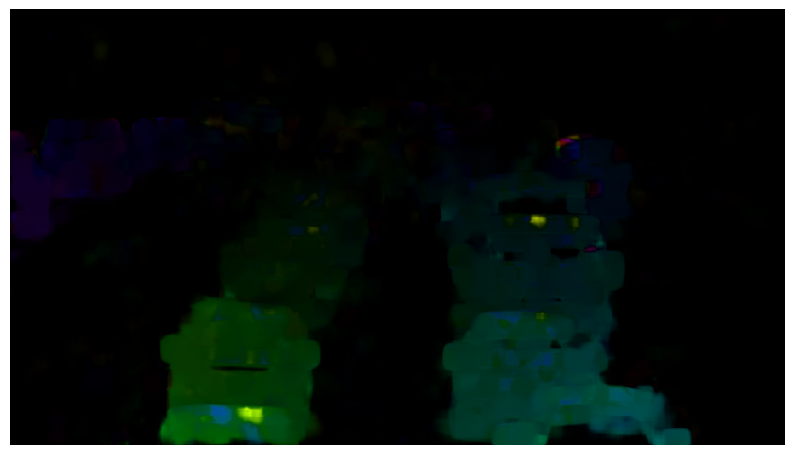

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def farneback_method(video_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Parameters for Farneback optical flow
    farneback_params = dict(pyr_scale=0.5, levels=5, winsize=11, iterations=10, poly_n=5, poly_sigma=1.1, flags=0)

    try:
        ret, frame1 = cap.read()
        if not ret:
            print("Error: Could not read first frame.")
            return
        prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        hsv = np.zeros_like(frame1)
        hsv[..., 1] = 255

        while True:
            ret, frame2 = cap.read()
            if not ret:
                break
            next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

            # Calculate optical flow
            flow = cv2.calcOpticalFlowFarneback(prvs, next, None, **farneback_params)

            # Compute the magnitude and angle of the flow vectors
            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

            # Set the hue according to the angle of the flow vectors
            hsv[..., 0] = ang * 180 / np.pi / 2

            # Set the value according to the magnitude of the flow vectors
            hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

            # Convert HSV to BGR
            bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

            # Display the frame with optical flow visualization
            plt.figure(figsize=(10, 6))
            plt.imshow(bgr)
            plt.axis('off')
            plt.show()

            # Clear the previous output
            clear_output(wait=True)

            # Update the previous frame
            prvs = next

    except KeyboardInterrupt:
        # Release the video capture object
        cap.release()

# Run the function with the video file path
video_path = "traffic.mp4"  # Adjust the path as per your directory structure
farneback_method(video_path)


# Lucas -Kanade

In [8]:
import cv2
import numpy as np

# Read the video
cap = cv2.VideoCapture('traffic.mp4')

# Check if the video is opened successfully
if not cap.isOpened():
    print("Error: Unable to open video.")
    exit()

# Create a Lucas-Kanade dense optical flow object
lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Read the first frame
ret, prev_frame = cap.read()

# Convert the first frame to grayscale
prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Create an HSV color image for visualization
hsv = np.zeros_like(prev_frame)
hsv[..., 1] = 255

# Create a named window for the optical flow
cv2.namedWindow('Dense Optical Flow', cv2.WINDOW_FULLSCREEN)

while True:
    # Read the next frame
    ret, next_frame = cap.read()
    if not ret:
        break
    
    # Convert the next frame to grayscale
    next_frame_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    
    # Compute dense optical flow using Lucas-Kanade method
    flow = cv2.calcOpticalFlowFarneback(prev_frame_gray, next_frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    
    # Convert the flow field from cartesian to polar coordinates
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    
    # Set hue according to the angle of the flow field
    hsv[..., 0] = angle * 180 / np.pi / 2
    
    # Set value according to the magnitude of the flow field
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    
    # Convert HSV to BGR for visualization
    flow_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    # Display the optical flow
    cv2.imshow('Dense Optical Flow', flow_rgb)
    
    # Update the previous frame and grayscale image
    prev_frame_gray = next_frame_gray
    
    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close all windows
cap.release()
cv2.destroyAllWindows()